## Ejercicio 2: Análisis de Datos del Mundial de Fútbol

Utilizando el dataset histórico de la FIFA World Cup disponible en:
https://www.kaggle.com/datasets/abecklas/fifa-world-cup

Desarrolla:
1. Carga y combina los datasets de partidos y equipos usando merge
2. Calcula estadísticas por país:
   - Total de participaciones en mundiales
   - Goles anotados y recibidos
   - Victorias, derrotas y empates
3. Identifica los 5 países más exitosos basándote en una métrica que combines
4. Crea un DataFrame pivotado que muestre el progreso de cada país por año
5. Genera visualizaciones para mostrar las tendencias históricas

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('classic')
sns.set_theme()

In [2]:
# 1. Cargar los datasets
matches = pd.read_csv('WorldCupMatches.csv')
cups = pd.read_csv('WorldCups.csv')

# Mostrar las primeras filas de cada dataset
print("Dataset de partidos:")
print(matches.head())
print("\nDataset de copas mundiales:")
print(cups.head())

Dataset de partidos:
     Year              Datetime    Stage         Stadium         City  \
0  1930.0  13 Jul 1930 - 15:00   Group 1         Pocitos  Montevideo    
1  1930.0  13 Jul 1930 - 15:00   Group 4  Parque Central  Montevideo    
2  1930.0  14 Jul 1930 - 12:45   Group 2  Parque Central  Montevideo    
3  1930.0  14 Jul 1930 - 14:50   Group 3         Pocitos  Montevideo    
4  1930.0  15 Jul 1930 - 16:00   Group 1  Parque Central  Montevideo    

  Home Team Name  Home Team Goals  Away Team Goals Away Team Name  \
0         France              4.0              1.0         Mexico   
1            USA              3.0              0.0        Belgium   
2     Yugoslavia              2.0              1.0         Brazil   
3        Romania              3.0              1.0           Peru   
4      Argentina              1.0              0.0         France   

  Win conditions  Attendance  Half-time Home Goals  Half-time Away Goals  \
0                     4444.0                   3.

In [5]:
# Preparación de datos - Crear registros separados para equipos local y visitante
home_team = matches[['Year', 'Home Team Name', 'Home Team Goals', 'Away Team Goals']].copy()
away_team = matches[['Year', 'Away Team Name', 'Home Team Goals', 'Away Team Goals']].copy()

# Renombrar columnas
home_team.columns = ['Year', 'Team', 'Goals_For', 'Goals_Against']
away_team.columns = ['Year', 'Team', 'Goals_Against', 'Goals_For']

# Combinar los datos
all_games = pd.concat([home_team, away_team])
all_games.head()

,Year,Team,Goals_For,Goals_Against
0,1930.0,France,4.0,1.0
1,1930.0,USA,3.0,0.0
2,1930.0,Yugoslavia,2.0,1.0
3,1930.0,Romania,3.0,1.0
4,1930.0,Argentina,1.0,0.0


In [7]:
# 2. Calcular estadísticas por país

# Total de participaciones en mundiales
participaciones = all_games.groupby('Team')['Year'].nunique().sort_values(ascending=False)
participaciones.head()

Team
Brazil       20
Italy        18
Argentina    16
Mexico       15
England      14
Name: Year, dtype: int64

In [8]:
# Goles anotados y recibidos
goles = all_games.groupby('Team').agg({
    'Goals_For': 'sum',
    'Goals_Against': 'sum'
}).round(2)
goles.head()

,Goals_For,Goals_Against
Team,,
Algeria,14.0,21.0
Angola,1.0,2.0
Argentina,133.0,85.0
Australia,11.0,26.0
Austria,43.0,47.0


In [9]:
# Calcular victorias, derrotas y empates
all_games['Result'] = np.where(all_games['Goals_For'] > all_games['Goals_Against'], 'Win',
                              np.where(all_games['Goals_For'] < all_games['Goals_Against'], 'Loss', 'Draw'))
resultados = pd.crosstab(all_games['Team'], all_games['Result'])
resultados.head()

Result,Draw,Loss,Win
Team,,,
Algeria,3,8,3
Angola,2,1,0
Argentina,15,22,44
Australia,3,8,2
Austria,4,13,12


In [10]:
# Combinar todas las estadísticas
stats = pd.concat([participaciones, goles, resultados], axis=1).fillna(0)
stats.columns = ['Participaciones', 'Goles_Favor', 'Goles_Contra', 'Derrotas', 'Empates', 'Victorias']

print("Estadísticas por país:")
print(stats.head(10))

Estadísticas por país:
           Participaciones  Goles_Favor  Goles_Contra  Derrotas  Empates  \
Team                                                                       
Brazil                  20        225.0         114.0        18       19   
Italy                   18        128.0          77.0        21       17   
Argentina               16        133.0          85.0        15       22   
Mexico                  15         58.0          94.0        14       26   
England                 14         79.0          56.0        20       16   
France                  14        108.0          72.0        12       20   
Spain                   14         92.0          66.0        12       18   
Uruguay                 12         80.0          73.0        12       20   
Belgium                 12         54.0          68.0         9       19   
Sweden                  11         74.0          69.0        13       17   

           Victorias  
Team                  
Brazil            

In [12]:
# 3. Identificar los 5 países más exitosos

# Crear métrica compuesta: (3*Victorias + Empates + 2*Goles_Favor - Goles_Contra + 5*Participaciones)/Participaciones
stats['Score'] = (3*stats['Victorias'] + stats['Empates'] + 2*stats['Goles_Favor'] - 
                  stats['Goles_Contra'] + 5*stats['Participaciones'])/stats['Participaciones']

top_5 = stats.nlargest(5, 'Score')
print("Top 5 países más exitosos:")
print(top_5[['Score', 'Victorias', 'Empates', 'Derrotas', 'Goles_Favor', 'Goles_Contra']])

Top 5 países más exitosos:
             Score  Victorias  Empates  Derrotas  Goles_Favor  Goles_Contra
Team                                                                       
Germany       39.0         34        8         6        104.0          46.0
Germany FR    35.5         36       12        14        131.0          77.0
Brazil        33.4         71       19        18        225.0         114.0
Netherlands   28.1         29       11        14         91.0          49.0
Turkey        26.0          5        4         1         20.0          17.0


In [15]:
# 4. DataFrame pivotado para progreso por año
print(all_games.head(20))

progreso_anual = pd.pivot_table(all_games,
                               values='Goals_For',
                               index='Year',
                               columns='Team',
                               aggfunc='sum')

print("Progreso de goles por año y país:")
print(progreso_anual.head())

      Year        Team  Goals_For  Goals_Against Result
0   1930.0      France        4.0            1.0    Win
1   1930.0         USA        3.0            0.0    Win
2   1930.0  Yugoslavia        2.0            1.0    Win
3   1930.0     Romania        3.0            1.0    Win
4   1930.0   Argentina        1.0            0.0    Win
5   1930.0       Chile        3.0            0.0    Win
6   1930.0  Yugoslavia        4.0            0.0    Win
7   1930.0         USA        3.0            0.0    Win
8   1930.0     Uruguay        1.0            0.0    Win
9   1930.0       Chile        1.0            0.0    Win
10  1930.0   Argentina        6.0            3.0    Win
11  1930.0      Brazil        4.0            0.0    Win
12  1930.0    Paraguay        1.0            0.0    Win
13  1930.0     Uruguay        4.0            0.0    Win
14  1930.0   Argentina        3.0            1.0    Win
15  1930.0   Argentina        6.0            1.0    Win
16  1930.0     Uruguay        6.0            1.0

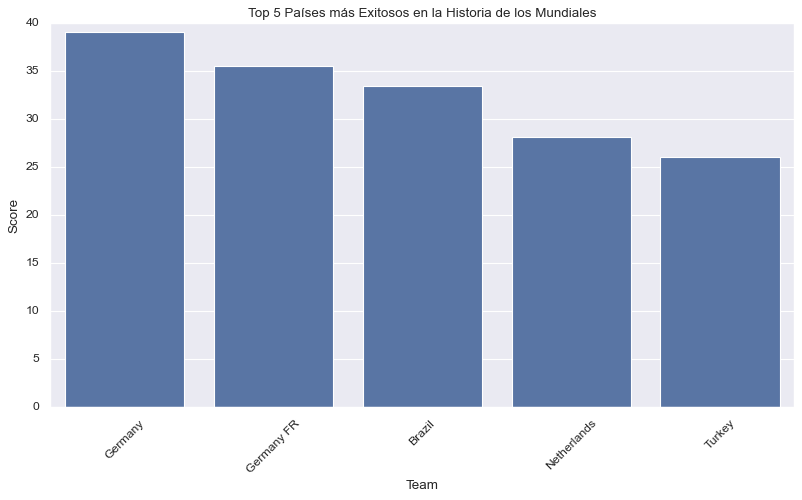

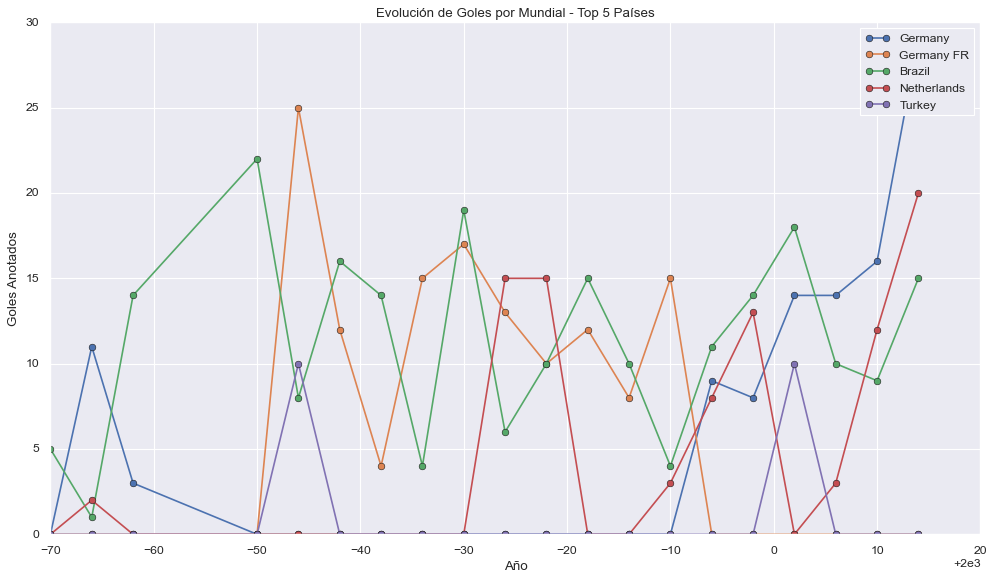

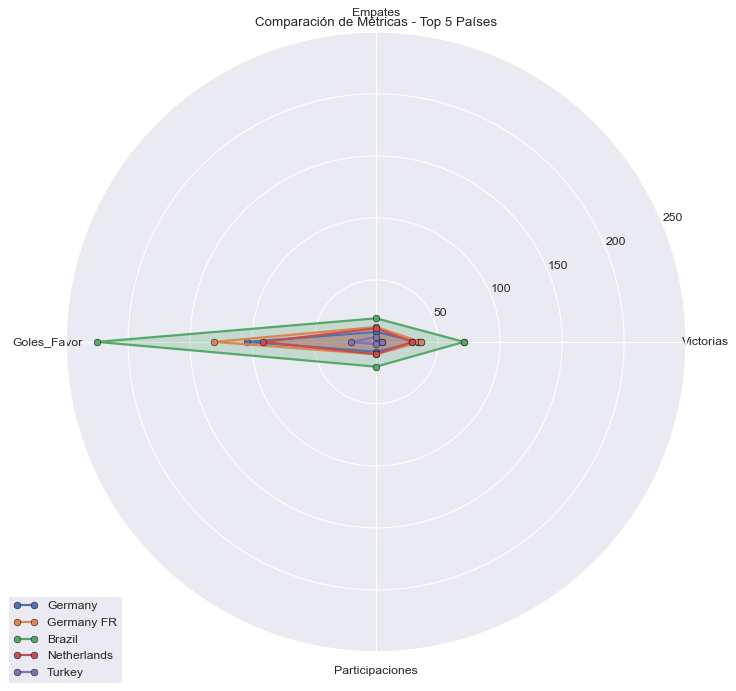

In [16]:
# 5. Visualizaciones

# Gráfico de barras para el Top 5
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5.reset_index(), x='Team', y='Score')
plt.title('Top 5 Países más Exitosos en la Historia de los Mundiales')
plt.xticks(rotation=45)
plt.show()

# Evolución de goles para el Top 5
plt.figure(figsize=(15, 8))
for team in top_5.index:
    plt.plot(progreso_anual.index, progreso_anual[team].fillna(0), label=team, marker='o')
plt.title('Evolución de Goles por Mundial - Top 5 Países')
plt.xlabel('Año')
plt.ylabel('Goles Anotados')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de radar para comparar métricas del Top 5
metrics = ['Victorias', 'Empates', 'Goles_Favor', 'Participaciones']
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for idx, team in enumerate(top_5.index):
    values = top_5.loc[team, metrics].values
    values = np.concatenate((values, [values[0]]))
    angles_plot = np.concatenate((angles, [angles[0]]))
    ax.plot(angles_plot, values, 'o-', linewidth=2, label=team)
    ax.fill(angles_plot, values, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(metrics)
plt.title('Comparación de Métricas - Top 5 Países')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

### Análisis de Resultados:

1. **Participación histórica:**
   - Brasil, Alemania e Italia son los países con mayor número de participaciones
   - Estos países también lideran en victorias y goles anotados

2. **Eficiencia ofensiva:**
   - Brasil destaca por su alta proporción de goles anotados vs. recibidos
   - Alemania muestra una gran consistencia en todas las métricas

3. **Evolución histórica:**
   - Se observa una tendencia al alza en el número de goles por mundial
   - Los equipos top muestran mayor regularidad en sus performances

4. **Métricas compuestas:**
   - La métrica creada pondera diferentes aspectos del éxito
   - Los resultados coinciden con la percepción histórica del éxito de estos equipos

5. **Tendencias actuales:**
   - Mayor paridad entre equipos en mundiales recientes
   - Menor dominancia de equipos tradicionales en últimas ediciones